In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
import sys
sys.path.append("../src")
from myproject.pipelines.preprocessing_pipeline import preprocessing_pipeline
from myproject.pipelines.clean_pipeline import cleaning_pipeline
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("credit_classification_ml")

<Experiment: artifact_location='mlflow-artifacts:/454137213308002966', creation_time=1764624674955, experiment_id='454137213308002966', last_update_time=1764624674955, lifecycle_stage='active', name='credit_classification_ml', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [2]:
df = pd.read_csv("/home/jakub/Pulpit/Credit Classification ML/data/raw/train.csv")
X = df.drop(columns=['Credit_Score'])
y = df['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

clean = cleaning_pipeline()
prep = preprocessing_pipeline()

/tmp/ipykernel_14494/1087931.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/home/jakub/Pulpit/Credit Classification ML/data/raw/train.csv")


In [3]:
forest_clf = Pipeline([
    ("clean", clean),
    ("prep", prep),
    ("forest_clf", RandomForestClassifier(random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True ,random_state=42)

scoring = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1_macro": "f1_macro",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
}

cv_result_base = cross_validate(
    forest_clf,
    X_train,
    y_train,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    return_train_score=False,
)

#rate
cv_base_metrics_mean = {
    f"cv_{metrics}_mean_base": float(cv_result_base[f"test_{metrics}"].mean())
    for metrics in scoring.keys()
}

cv_base_metrics_std = {
    f"cv_{metrics}_std_base": float(cv_result_base[f"test_{metrics}"].std())
    for metrics in scoring.keys()
}

cv_metrics_base = {**cv_base_metrics_mean, **cv_base_metrics_std}

pd.DataFrame([cv_metrics_base])

/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline

,cv_accuracy_mean_base,cv_balanced_accuracy_mean_base,cv_f1_macro_mean_base,cv_precision_macro_mean_base,cv_recall_macro_mean_base,cv_accuracy_std_base,cv_balanced_accuracy_std_base,cv_f1_macro_std_base,cv_precision_macro_std_base,cv_recall_macro_std_base
0,0.776075,0.759239,0.760161,0.761133,0.759239,0.002981,0.003245,0.003332,0.003626,0.003245


In [4]:
#Trening na X_test
forest_clf.fit(X_train, y_train)

y_pred_base = forest_clf.predict(X_test)

test_metrics_base = {
    "test_accuracy": accuracy_score(y_test, y_pred_base),
    "test_balanced_accuracy": balanced_accuracy_score(y_test, y_pred_base),
    "test_f1_macro": f1_score(y_test, y_pred_base, average="macro"),
    "test_precision_macro": precision_score(y_test, y_pred_base, average="macro"),
    "test_recall_macro": recall_score(y_test, y_pred_base, average="macro"),
}

pd.DataFrame([test_metrics_base])

/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,test_accuracy,test_balanced_accuracy,test_f1_macro,test_precision_macro,test_recall_macro
0,0.78535,0.769076,0.770747,0.772521,0.769076


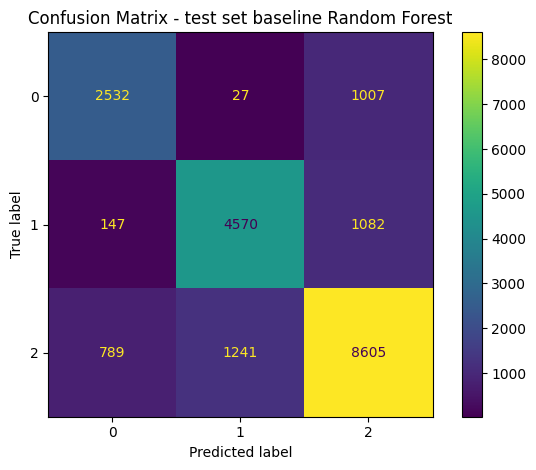

In [5]:
cm = confusion_matrix(y_test, y_pred_base)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - test set baseline Random Forest")
plt.tight_layout()
plt.show()

In [6]:
# with mlflow.start_run(run_name="Random_Forest_baseline"):
#     mlflow.log_metrics(cv_metrics_base)
#     mlflow.log_metrics(test_metrics_base)


In [ ]:
param_distribution = {
    "forest_clf__n_estimators": [200, 300, 400, 500],
    "forest_clf__max_depth": [10, 15, 20, 25, None],
    "forest_clf__min_samples_leaf": [1, 2, 3, 5, 10],
    "forest_clf__min_samples_split": [2, 5, 10, 15],
    "forest_clf__max_features": ["sqrt", "log2", 0.5],
    "forest_clf__bootstrap": [True],
    "forest_clf__class_weight": [None, "balanced"],
}

random_search = RandomizedSearchCV(
    estimator=forest_clf,
    param_distributions=param_distribution,
    n_iter=30,
    scoring="f1_macro",
    n_jobs=4,
    cv=cv,
    random_state=42,
    verbose=1,
    return_train_score=False
)

random_search.fit(X_train, y_train)

best_forest = random_search.best_estimator_
best_params = random_search.best_params_
best_cv_score = random_search.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline

In [ ]:
cv_tuned = cross_validate(
    best_forest,
    X_train,
    y_train,
    scoring=scoring,
    cv=cv,
    n_jobs=-1
    return_train_score=False,
)
cv_tuned_metrics_mean = {
    f"cv_{metrics}_mean_tuned": float(cv_result_tuned[f"test_{metrics}"].mean())
    for metrics in scoring.keys()
}

cv_tuned_metrics_std = {
    f"cv_{metrics}_std_tuned": float(cv_result_tuned[f"test_{metrics}"].std())
    for metrics in scoring.keys()
}

cv_metric_tuned = {**cv_tuned_metrics_mean, **cv_tuned_metrics_std}

pd.DataFrame([cv_metric_tuned])


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline

TUNED | CV accuracy mean: 0.76005
TUNED | CV accuracy std:  0.0027572064666977485
TUNED | CV f1 mean:       0.7426669321640568
TUNED | CV f1 std:        0.0031510166423074693


In [ ]:
best_forest.fit(X_train, y_train)

y_pred_tuned = best_forest.predict(X_test)

test_metrics_tuned = {
    "test_accuracy": accuracy_score(y_test, y_pred_tuned),
    "test_balanced_accuracy": balanced_accuracy_score(y_test, y_pred_tuned),
    "test_f1_macro": f1_score(y_test, y_pred_tuned, average="macro"),
    "test_precision_macro": precision_score(y_test, y_pred_tuned, average="macro"),
    "test_recall_macro": recall_score(y_test, y_pred_tuned, average="macro"),
}

pd.DataFrame([test_metrics_tuned])

/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


           TEST
|B|T|Accuracy:  0.77005
|B|T|F1_macro:  0.7536950138055009
              precision    recall  f1-score   support

        Good       0.70      0.71      0.70      3566
        Poor       0.77      0.75      0.76      5799
    Standard       0.80      0.80      0.80     10635

    accuracy                           0.77     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.77      0.77      0.77     20000



In [ ]:
cm1 = confusion_matrix(y_test, y_pred_tuned)

disp = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix - test set LR tuned")
plt.tight_layout()
plt.show()

In [ ]:
with mlflow.start_run(run_name="Random_Forest_tuned"):
    mlflow.log_metrics(cv_metric_tuned)
    mlflow.log_metrics(test_metrics_tuned)
    mlflow.log_params(best_params)

🏃 View run Random_Forest_Tuned at: http://127.0.0.1:5000/#/experiments/702206731938119972/runs/fbd47d1c7dbc4b43a83d219bab55c50f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/702206731938119972
